<a href="https://colab.research.google.com/github/abouelgoud/sas/blob/master/DatesClassification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install -q tf-hub-nightly==0.8.0.dev201911110007

     |████████████████████████████████| 92kB 2.8MB/s 


In [3]:
!pip install -q git+https://github.com/tensorflow/examples

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_customization.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_customization.core.task import image_classifier
from tensorflow_examples.lite.model_customization.core.task.model_spec import efficientnet_b0_spec
from tensorflow_examples.lite.model_customization.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

In [5]:
image_path = tf.keras.utils.get_file(      'flower_photos',      'http://hamzaagh-001-site8.itempurl.com/RaghadDates.tar.gz',      untar=True)

13328384/13325550 [==============================] - 15s 1us/step


In [6]:
image_path


'/root/.keras/datasets/flower_photos'

In [7]:
data = ImageClassifierDataLoader.from_folder('/root/.keras/datasets/')

INFO:tensorflow:Load image with size: 64, num_label: 2, labels: Ekhlas, Sukkary.


In [8]:
model = image_classifier.create(data)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Train for 1 steps
Epoch 1/5


1/1 [==============================] - 9s 9s/step - loss: 1.1656 - accuracy: 0.5625 - val_loss: inf - val_accuracy: 0.6667


/tensorflow-2.0.0/python3.6/tensorflow_core/python/keras/engine/training_utils.py:141: RuntimeWarning: divide by zero encountered in double_scalars
  self.results[0] /= (self.num_samples or self.steps)


In [9]:
loss, accuracy = model.evaluate()

1/1 [==============================] - 0s 357ms/step - loss: 0.4758 - accuracy: 1.0000


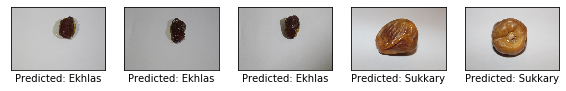

In [10]:
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(model.test_data.dataset.take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  # Pre-processing should remain the same. Currently, just normalize each pixel value to [0, 1] and resize image to [224, 224, 3].
  image, _ = model.preprocess_image(image, label)
  # Add batch dimension and convert to float32 to match with the model's input
  # data format.
  image = tf.expand_dims(image, 0).numpy()

  predict_prob = model.model.predict(image)
  predict_label = np.argmax(predict_prob, axis=1)[0]

  ax.xaxis.label.set_color(get_label_color(predict_label,\
                                           label.numpy()))
  plt.xlabel('Predicted: %s' % model.test_data.index_to_label[predict_label])
plt.show()

In [11]:
model.export('image_classifier.tflite', 'image_labels.txt')

INFO:tensorflow:Export to tflite model image_classifier.tflite, saved labels in image_labels.txt.


INFO:tensorflow:Export to tflite model image_classifier.tflite, saved labels in image_labels.txt.


In [12]:
# Read TensorFlow Lite model from TensorFlow Lite file.
import os

with tf.io.gfile.GFile('image_classifier.tflite', 'rb') as f:
  model_content = f.read()
  # urllib.request.urlretrieve('image_classifier.tflite', '/Users/17361/Downloads/image_classifier.tflite')
  tf.io.gfile.copy('image_classifier.tflite','/root/.keras/image_classifier.tflite')

# Read label names from label file.
with tf.io.gfile.GFile('image_labels.txt', 'r') as f:
  label_names = f.read().split('\n')

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

# Run predictions on each test image data and calculate accuracy.
accurate_count = 0
for i, (image, label) in enumerate(model.test_data.dataset):
    # Pre-processing should remain the same. Currently, just normalize each pixel value and resize image according to the model's specification.
    image, _ = model.preprocess_image(image, label)
    # Add batch dimension and convert to float32 to match with the model's input
    # data format.
    image = tf.expand_dims(image, 0).numpy()

    # Run inference.
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the label with highest
    # probability.
    predict_label = np.argmax(output()[0])
    # Get label name with label index.
    predict_label_name = label_names[predict_label]

    accurate_count += (predict_label == label.numpy())

accuracy = accurate_count * 1.0 / model.test_data.size
print('TensorFlow Lite model accuracy = %.4f' % accuracy)

TensorFlow Lite model accuracy = 1.0000
